In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [7]:
def computeDifferenceOfGaussians(blurred_images):
    # The number of octaves can be inferred from the length of blurred_images
    num_octaves = len(blurred_images)
    dogs = []
    for i, img in enumerate(blurred_images):
        dog = np.zeros(img.shape - np.array([0, 0, 1]))
        num_dogs_per_octave = dog.shape[2]
        for dog_idx in range(num_dogs_per_octave):
            dog[:, :, dog_idx] = np.abs( img[:, :, dog_idx+1] - img[:, :, dog_idx] )
        dogs.append(dog)
    return dogs

def computeImagePyramid(img, num_octaves):
    image_pyramid = []
    image_pyramid.append(img)
    for i in range(num_octaves - 1):
        image_pyramid.append(cv2.resize(image_pyramid[i], (0,0), fx = 0.5, fy = 0.5))
    return image_pyramid

def extractKeypoints(diff_of_gaussians, contrast_threshold):
    # returns the keypoint locations
    num_octaves = len(diff_of_gaussians)
    keypoint_locations = []
    for oct_idx, dog in enumerate(diff_of_gaussians):
        dog_max = scipy.ndimage.maximum_filter(dog, [3,3,3])
        is_keypoint = (dog == dog_max) & (dog >= contrast_threshold)
        is_keypoint[:, :, 0] = False
        is_keypoint[:, :, -1] = False
        keypoint_locations.append( np.array(is_keypoint.nonzero()).T )
    return keypoint_locations

def computeBlurredImages(image_pyramid, num_scales, sift_sigma):
    # The number of octaves can be inferred from the length of the image pyramid
    num_octaves = len(image_pyramid)
    imgs_per_oct = num_scales + 3
    blurred_images = []
    for oct_idx, img in enumerate(image_pyramid):
        octave_stack = np.zeros(np.r_[img.shape, imgs_per_oct])
        for stack_idx in range(imgs_per_oct):
            gauss_blur_sigma = sift_sigma * 2**((stack_idx-1)/num_scales)
            filter_size = int(2*np.ceil(2*gauss_blur_sigma)+1.0)
            octave_stack[:, :, stack_idx] = \
                    cv2.GaussianBlur(img, (filter_size,filter_size), gauss_blur_sigma)
        blurred_images.append(octave_stack)
    return blurred_images

def getGaussianKernel(size, sigma):
    x = np.linspace(-(size - 1) / 2.0, (size-1)/2.0, size)
    gauss = np.exp(-0.5 * np.square(x) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def getImageGradient(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    angle = np.arctan2(-sobely, sobelx) * 180/np.pi
    return magnitude, angle

def derotatePatch(img, loc, patch_size, orientation):
    # it can't be worse than a 45 degree rotation, so lets pad 
    # under this assumption. Then it will be enough for sure.
    padding = int(np.ceil(np.sqrt(2) * patch_size / 2))
    derotated_patch = np.zeros((patch_size,patch_size))
    padded_img = cv2.copyMakeBorder(img, padding, padding, 
            padding, padding, cv2.BORDER_CONSTANT, 0)
    ori_rad = orientation * np.pi/180
    
    # compute derotated patch  
    for px in range(patch_size):
        for py in range(patch_size):            
            x_origin = px - patch_size/2
            y_origin = py - patch_size/2
            # rotate patch by angle ori
            x_rotated = np.cos(ori_rad) * x_origin - np.sin(ori_rad) * y_origin
            y_rotated = np.sin(ori_rad) * x_origin + np.cos(ori_rad) * y_origin
            # move coordinates to patch
            x_patch_rotated = loc[1] + x_rotated
            y_patch_rotated = loc[0] - y_rotated
            # sample image (using nearest neighbor sampling as opposed to more
            # accuracte bilinear sampling)
            y_img_padded = int(np.ceil(y_patch_rotated + padding))
            x_img_padded = int(np.ceil(x_patch_rotated + padding))
            derotated_patch[py, px] = padded_img[y_img_padded, x_img_padded]
    # Return the patch
    return derotated_patch

def computeDescriptors(blurred_images, keypoint_locations, rotation_invariant):
    # return descriptors and final keypoint locations
    num_octaves = len(blurred_images)
    assert(num_octaves == len(keypoint_locations))

    descriptors = []
    final_keypoint_locations = []

    # The factor of 1.5 is taken from Lowe's paper
    gauss_window = getGaussianKernel(16, 16 * 1.5)
    for oct_idx, (imgs, locs) in enumerate(zip(blurred_images, keypoint_locations)):

        # Only consider images that contain at least one keypoint, i.e.
        # where the image index appears at least once in locs[:, 2]
        for img_idx in np.unique(locs[:,2]):
            curr_img = imgs[:, :, img_idx]
            rows_img, cols_img = curr_img.shape[:2]
            Gmag, Gdir = getImageGradient(curr_img)

            # Select all keypoints that occur in the current image
            # and then discard the image information, e.g. keep only x, y position
            curr_loc = locs[locs[:,2] == img_idx, :2]

            num_keypoints = curr_loc.shape[0]
            curr_descriptors = np.zeros((num_keypoints, 128))
            is_valid_keypoint = np.zeros((num_keypoints,), dtype=bool)
            for idx_keypoint in range(num_keypoints):
                row, col = curr_loc[idx_keypoint, :]
                if row > 7 and col > 7 and row < rows_img-7 and col < cols_img-7:
                    is_valid_keypoint[idx_keypoint] = True

                    # get the local patches of gradient and direction
                    Gmag_loc = Gmag[row-8:row+8, col-8:col+8]
                    Gmag_loc_w = Gmag[row-8:row+8, col-8:col+8] * gauss_window
                    Gdir_loc = Gdir[row-8:row+8, col-8:col+8]

                    if rotation_invariant:
                        # compute dominant direction through looking at the most
                        # common orientation in the histogram, spaced at 10 deg
                        angle_edges = np.arange(-180, 181, 10) 
                        orient_hist, _ = np.histogram(Gdir_loc[:], 
                                bins = angle_edges, weights = Gmag_loc_w[:])
                        max_orient_idx = np.argmax(orient_hist)
                        Gdir_loc_principal = np.mean(angle_edges[max_orient_idx:max_orient_idx+1])
                        patch_derotated = derotatePatch(curr_img, [row, col], 
                            16, Gdir_loc_principal);
                        Gmag_derot, Gdir_derot = getImageGradient(patch_derotated)
                        Gmag_loc = Gmag_derot
                        Gmag_loc_w = Gmag_derot * gauss_window
                        Gdir_loc = Gdir_derot

                    N_tmp = 0
                    for ix in range(4):
                        for iy in range(4):
                            mag_4by4 = Gmag_loc_w[4*ix:4*(ix+1), 4*iy:4*(iy+1)]
                            dir_4by4 = Gdir_loc[4*ix:4*(ix+1), 4*iy:4*(iy+1)]
                            angles = np.arange(-180, 181, 45)
                            N_w, _ = np.histogram(dir_4by4[:], bins = angles, weights = mag_4by4[:])
                            curr_descriptors[idx_keypoint, N_tmp:N_tmp+8] = N_w
                            N_tmp += 8
            
            # Adapt keypoint location such that they correspond to the
            # originial image dimensions.
            curr_loc = curr_loc * 2**oct_idx;
            # Only store valid keypoints.
            descriptors.append(curr_descriptors[is_valid_keypoint, :])
            final_keypoint_locations.append(curr_loc[is_valid_keypoint,:])

    descriptors = np.concatenate(descriptors)
    descriptors /= np.linalg.norm(descriptors, ord=2, axis=1, keepdims = True)
    final_keypoint_locations = np.concatenate(final_keypoint_locations)

    return descriptors, final_keypoint_locations 

In [8]:
# User parameters
rotation_invariant =True       # Enable rotation invariant SIFT
rotation_img2_deg = 60          # Rotate the second image to be matched

# sift parameters
contrast_threshold = 0.04       # for feature matching
sift_sigma = 1.0                # sigma used for blurring
rescale_factor = 0.3            # rescale images to make it faster
num_scales = 3                  # number of scales per octave
num_octaves = 5                 # number of octaves

In [9]:
# Convenience function to read in images into grayscale and convert them to double 
get_image = lambda fname, scale: cv2.normalize(cv2.resize( cv2.imread(fname, cv2.IMREAD_GRAYSCALE), (0,0), fx = scale, fy = scale).astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Read in images
img1 = get_image("./data/img_1.jpg", rescale_factor)
img2 = get_image("./data/img_2.jpg", rescale_factor)


# If we want to test our rotation invariant features, rotate the second image
if np.abs(rotation_img2_deg) > 1e-6:
    pass
    # Lets go and rotate the image
    # - get the original height and width
    # - create rotation matrix
    # - calculate the size of the rotated image
    # - pad the image
    # - rotate the image
    (h, w) = img2.shape[:2]
    rotate_img = cv2.getRotationMatrix2D((w/2,h/2), rotation_img2_deg, 1.0)
    corner = np.array([[h, h, 0, 0], [w, 0, w, 0], [1, 1, 1, 1]])
    size_rotate_img = np.ptp(rotate_img @ corner, axis = 1)
    h_rot, w_rot = size_rotate_img.astype('int')
    dh = int(np.ceil((h_rot - h)/2))
    dw = int(np.ceil((w_rot - w)/2))
    img_padded = cv2.copyMakeBorder(img2, dh, dh, dw, dw, cv2.BORDER_CONSTANT, 0)
    rotate_img = cv2.getRotationMatrix2D((w_rot/2,h_rot/2), rotation_img2_deg, 1.0)
    img2 = cv2.warpAffine(img_padded, rotate_img, (w_rot, h_rot))


# Actually compute the SIFT features. For both images do:
# - construct the image pyramid
# - compute the blurred images
# - compute difference of gaussians
# - extract the keypoints
# - compute the descriptors
imgs = [img1, img2]
keypoint_locations = []
keypoint_descriptors = []

for i in range(len(imgs)):
    pass
    image_pyramid = computeImagePyramid(imgs[i], num_octaves)
    blurred_images = computeBlurredImages(image_pyramid, num_scales, sift_sigma)
    diff_of_gaussians = computeDifferenceOfGaussians(blurred_images)
    tmp_keypoint_locs = extractKeypoints(diff_of_gaussians, contrast_threshold)
    desc, locs = computeDescriptors(blurred_images, tmp_keypoint_locs, rotation_invariant)

    # Store the information
    keypoint_locations.append(locs)
    keypoint_descriptors.append(desc)

# OpenCV brute force matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(keypoint_descriptors[0].astype(np.float32), keypoint_descriptors[1].astype(np.float32), 2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance or n.distance < 0.8*m.distance:
        good.append(m)



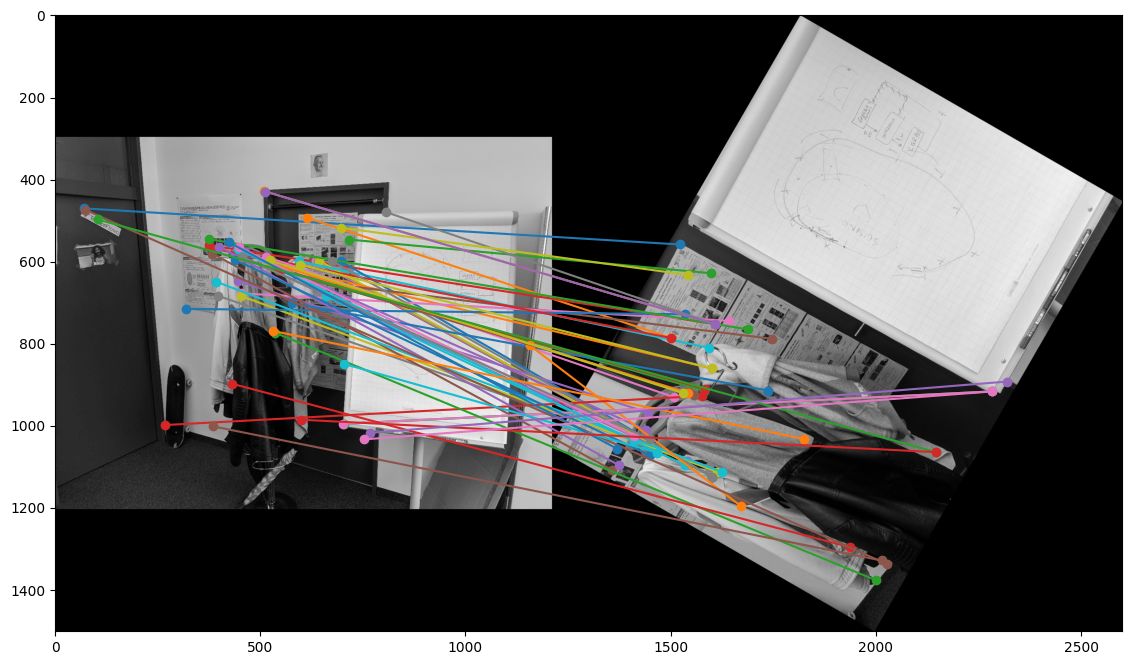

In [13]:
# Plot the results
plt.figure(figsize=(24,8))
dh = int(img2.shape[0] - img1.shape[0])
top_padding = int(dh/2)
img1_padded = cv2.copyMakeBorder(img1, top_padding, dh - int(dh/2),
        0, 0, cv2.BORDER_CONSTANT, 0)
plt.imshow(np.c_[img1_padded, img2], cmap = "gray")

for match in good:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    x1 = keypoint_locations[0][img1_idx,1]
    y1 = keypoint_locations[0][img1_idx,0] + top_padding
    x2 = keypoint_locations[1][img2_idx,1] + img1.shape[1]
    y2 = keypoint_locations[1][img2_idx,0]
    plt.plot(np.array([x1, x2]), np.array([y1, y2]), "o-")
plt.show()